In [1]:
import torch
import torch.nn as nn

class UnrolledPrimalDualDenoising(nn.Module):
    def __init__(self, num_iterations, lambda_map):
        super(UnrolledPrimalDualDenoising, self).__init__()
        self.num_iterations = num_iterations
        self.lambda_map = lambda_map

    def forward(self, noisy_image):
        # Initialize primal and dual variables
        u = noisy_image.clone()
        p = torch.zeros_like(noisy_image)

        # Algorithm parameters
        tau = 0.25
        sigma = 0.25
        theta = 1.0

        for _ in range(self.num_iterations):
            # Dual update
            grad_u = torch.gradient(u)[0]
            p = p + sigma * grad_u
            p = p / (1 + sigma * self.lambda_map)

            # Primal update
            div_p = -torch.gradient(p)[0]
            u_old = u.clone()
            u = (u + tau * div_p) / (1 + tau * self.lambda_map)

            # Extragradient step
            u = u + theta * (u - u_old)

        return u

# Example usage:
if __name__ == "__main__":
    # Parameters
    num_iterations = 50
    image_size = (1, 256, 256)  # Example image size (1, height, width)

    # Dummy data
    noisy_image = torch.rand(image_size)  # Replace with your noisy image
    lambda_map = torch.rand(image_size)   # Replace with your Lambda map

    # Model
    model = UnrolledPrimalDualDenoising(num_iterations, lambda_map)

    # Denoise the image
    denoised_image = model(noisy_image)

    print("Denoised image shape:", denoised_image.shape)


RuntimeError: torch.gradient expected each dimension size to be at least edge_order+1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UnrolledPrimalDualDenoising(nn.Module):
    def __init__(self, num_iterations, lambda_map):
        super(UnrolledPrimalDualDenoising, self).__init__()
        self.num_iterations = num_iterations
        self.lambda_map = lambda_map

        # Define convolutional kernels for gradient computation
        self.grad_x = nn.Conv2d(1, 1, kernel_size=(1, 2), stride=1, padding=(0, 1), bias=False)
        self.grad_y = nn.Conv2d(1, 1, kernel_size=(2, 1), stride=1, padding=(1, 0), bias=False)
        self.grad_x.weight.data = torch.tensor([[[[-1, 1]]]], dtype=torch.float32)
        self.grad_y.weight.data = torch.tensor([[[[-1], [1]]]], dtype=torch.float32)

    def forward(self, noisy_image):
        # Initialize primal and dual variables
        u = noisy_image.clone()
        p_x = torch.zeros_like(noisy_image)
        p_y = torch.zeros_like(noisy_image)

        # Algorithm parameters
        tau = 0.25
        sigma = 0.25
        theta = 1.0

        for _ in range(self.num_iterations):
            # Dual update
            grad_u_x = self.grad_x(u)
            grad_u_y = self.grad_y(u)
            p_x = p_x + sigma * grad_u_x
            p_y = p_y + sigma * grad_u_y
            norm_p = torch.max(torch.ones_like(p_x), torch.sqrt(p_x**2 + p_y**2))
            p_x = p_x / norm_p
            p_y = p_y / norm_p

            # Primal update
            div_p_x = self.grad_x(p_x)
            div_p_y = self.grad_y(p_y)
            div_p = div_p_x + div_p_y
            u_old = u.clone()
            u = (u + tau * div_p) / (1 + tau * self.lambda_map)

            # Extragradient step
            u = u + theta * (u - u_old)

        return u

# Example usage:
if __name__ == "__main__":
    # Parameters
    num_iterations = 50
    image_size = (1, 256, 256)  # Example image size (batch_size, height, width)

    # Dummy data
    noisy_image = torch.rand(image_size).unsqueeze(0)  # Add batch dimension
    lambda_map = torch.rand(image_size).unsqueeze(0)   # Add batch dimension

    # Model
    model = UnrolledPrimalDualDenoising(num_iterations, lambda_map)

    # Denoise the image
    denoised_image = model(noisy_image)

    print("Denoised image shape:", denoised_image.shape)


RuntimeError: The size of tensor a (256) must match the size of tensor b (257) at non-singleton dimension 3

In [3]:
import torch
import torch.nn as nn

class UnrolledPrimalDualDenoising(nn.Module):
    def __init__(self, num_iterations, lambda_map):
        super(UnrolledPrimalDualDenoising, self).__init__()
        self.num_iterations = num_iterations
        self.lambda_map = lambda_map

        # Define convolutional kernels for gradient computation
        self.grad_x = nn.Conv2d(1, 1, kernel_size=(1, 2), stride=1, padding=(0, 1), bias=False)
        self.grad_y = nn.Conv2d(1, 1, kernel_size=(2, 1), stride=1, padding=(1, 0), bias=False)
        self.grad_x.weight.data = torch.tensor([[[[-1, 1]]]], dtype=torch.float32)
        self.grad_y.weight.data = torch.tensor([[[[-1], [1]]]], dtype=torch.float32)

        # Define convolutional kernels for divergence computation
        self.div_x = nn.Conv2d(1, 1, kernel_size=(1, 2), stride=1, padding=(0, 1), bias=False)
        self.div_y = nn.Conv2d(1, 1, kernel_size=(2, 1), stride=1, padding=(1, 0), bias=False)
        self.div_x.weight.data = torch.tensor([[[[1, -1]]]], dtype=torch.float32)
        self.div_y.weight.data = torch.tensor([[[[1], [-1]]]], dtype=torch.float32)

    def forward(self, noisy_image):
        # Initialize primal and dual variables
        u = noisy_image.clone()
        p_x = torch.zeros_like(noisy_image)
        p_y = torch.zeros_like(noisy_image)

        # Algorithm parameters
        tau = 0.25
        sigma = 0.25
        theta = 1.0

        for _ in range(self.num_iterations):
            # Dual update
            grad_u_x = self.grad_x(u)
            grad_u_y = self.grad_y(u)
            p_x = p_x + sigma * grad_u_x[:, :, :, :-1]
            p_y = p_y + sigma * grad_u_y[:, :, :-1, :]
            norm_p = torch.max(torch.ones_like(p_x), torch.sqrt(p_x**2 + p_y**2))
            p_x = p_x / norm_p
            p_y = p_y / norm_p

            # Primal update
            div_p_x = self.div_x(p_x)
            div_p_y = self.div_y(p_y)
            div_p = div_p_x[:, :, :, 1:] + div_p_y[:, :, 1:, :]
            u_old = u.clone()
            u = (u + tau * div_p) / (1 + tau * self.lambda_map)

            # Extragradient step
            u = u + theta * (u - u_old)

        return u

# Example usage:
if __name__ == "__main__":
    # Parameters
    num_iterations = 50
    image_size = (1, 256, 256)  # Example image size (batch_size, height, width)

    # Dummy data
    noisy_image = torch.rand(image_size).unsqueeze(0)  # Add batch dimension
    lambda_map = torch.rand(image_size).unsqueeze(0)   # Add batch dimension

    # Model
    model = UnrolledPrimalDualDenoising(num_iterations, lambda_map)

    # Denoise the image
    denoised_image = model(noisy_image)

    print("Denoised image shape:", denoised_image.shape)


Denoised image shape: torch.Size([1, 1, 256, 256])


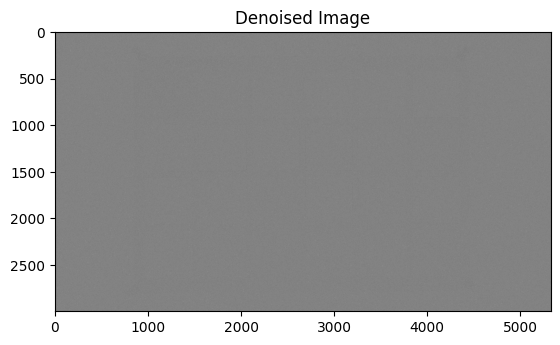

In [22]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path):
    # Load the image
    image = Image.open(image_path)
    
    # Convert to grayscale if the image is in color
    if image.mode != 'L':
        image = image.convert('L')
    
    # Convert the image to a NumPy array
    image_np = np.array(image, dtype=np.float32)
    
    # Normalize the pixel values to the range [0, 1]
    image_np = image_np / 255.0
    
    # Convert the NumPy array to a PyTorch tensor
    image_tensor = torch.from_numpy(image_np)
    
    # Add batch and channel dimensions
    image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)
    
    return image_tensor

# Load the image
# image_path = 'path_to_your_image.jpg'  # Replace with your image path
image_path = './SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/GT_SRGB_010.PNG'  # Replace with your image path
noisy_image = load_image(image_path)

# Assuming lambda_map is also provided or computed separately
lambda_map = torch.rand_like(noisy_image)

# Model
num_iterations = 50
model = UnrolledPrimalDualDenoising(num_iterations, lambda_map)

# Denoise the image
denoised_image = model(noisy_image)

# Display the results
denoised_image = denoised_image.squeeze(0).squeeze(0).detach().numpy()
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image')
plt.show()


In [21]:
import torch

from PIL import Image
import matplotlib.pyplot as plt

def load_image(image_path, transform=None):
    # Load the image
    image = Image.open(image_path)
    
    # Convert to grayscale if the image is in color
    if image.mode != 'L':
        image = image.convert('L')
    
    # Apply transformations
    if transform is not None:
        image = transform(image)
    
    # Add batch dimension
    image = image.unsqueeze(0)
    
    return image

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the image
image_path = './SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/GT_SRGB_010.PNG'  # Replace with your image path
noisy_image = load_image(image_path, transform)

# Assuming lambda_map is also provided or computed separately
lambda_map = torch.rand_like(noisy_image)

# Model
num_iterations = 50
model = UnrolledPrimalDualDenoising(num_iterations, lambda_map)

# Denoise the image
denoised_image = model(noisy_image)

# Display the results
denoised_image = denoised_image.squeeze(0).squeeze(0).detach().numpy()
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image')
plt.show()


RuntimeError: operator torchvision::nms does not exist

In [4]:
import os
# TODO: CHANGE THIS TO YOUR PATH
# NOTE: Windows uses \\ instead of /
DATA_PATH = './SIDD_Small_sRGB_Only/Data'
def load_images(ids: list, take_npy_files: bool) -> list:
    data_path = DATA_PATH
    k = 0

    images = []

    for folder in os.listdir(data_path):
        img_id = folder[:4]	# The first 4 characters of folder name is the image id (0001, 0002, ..., 0200)
        if img_id not in ids:
            continue
        k += 1
        print(f'loading image id {img_id}, {k}/{len(ids)}')

        files_path = os.path.join(data_path, folder)

        # if take_npy_files:
        #     xf = get_npy_file(files_path, scale_factor)
        #     images.append(xf)
        #     continue

        # Use only the ground truth images
        file = "GT_SRGB_010.PNG"  # GT = Ground Truth

        image = Image.open(os.path.join(files_path, file))
        assert image.mode == 'RGB', f"Image mode is not RGB: {image.mode}" # For now, expect RGB images
        # width, height = image.size
        # Width and height are NOT always the same
        # assert (width, height) == (5328, 3000), f"Image size is not 5328x3000: {image.size}" # For now, expect 5328x3000 images

        images.append(image)

    return images

In [5]:
def resize_image(image, scale_factor):
    Nx_,Ny_ = int(np.floor(scale_factor * image.width )), int(np.floor(scale_factor * image.height ))
    image = image.resize( (Nx_, Ny_) )
    return image

In [6]:
def convert_to_numpy(image):
    image_data = np.asarray(image)
    return image_data

In [7]:
def convert_to_tensor(image_data):
    xf = []
    xf.append(image_data)
    xf = np.stack(xf, axis=-1)
    xf = torch.tensor(xf, dtype=torch.float)
    xf = xf.unsqueeze(0) / 255
    return xf

In [8]:
# CODE TO ADD NOISE HERE
def get_variable_noise(sigma_min, sigma_max):
    return sigma_min + torch.rand(1) * (sigma_max - sigma_min)

def add_noise(xf: torch.tensor, sigma) -> torch.tensor:
    std = torch.std(xf)
    mu = torch.mean(xf)

    x_centred = (xf  - mu) / std

    x_centred += sigma * torch.randn(xf.shape, dtype = xf.dtype)

    xnoise = std * x_centred + mu

    return xnoise

In [9]:
def PSNR(original, compressed): 
    mse = torch.mean((original - compressed) ** 2) 
    if(mse == 0): # MSE is zero means no noise is present in the signal. 
                  # Therefore PSNR have no importance. 
        return 100
    # max_pixel = 255.0
    max_pixel = 1.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse)) 
    return psnr

loading image id 0065, 1/1
Image data shape: (380, 506)
Image size: torch.Size([1, 380, 506, 1])
PSNR of original image: 100 dB


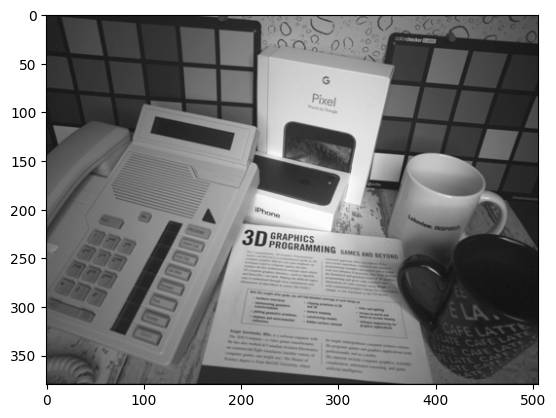

PSNR of constant noise image: 20.26 dB


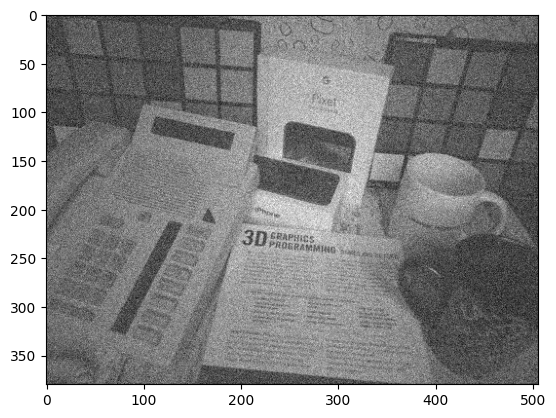

PDHG input size: torch.Size([1, 1, 380, 506])
Reconstructed image data shape: torch.Size([1, 1, 1, 380, 506])


TypeError: Invalid shape (1, 380, 506) for image data

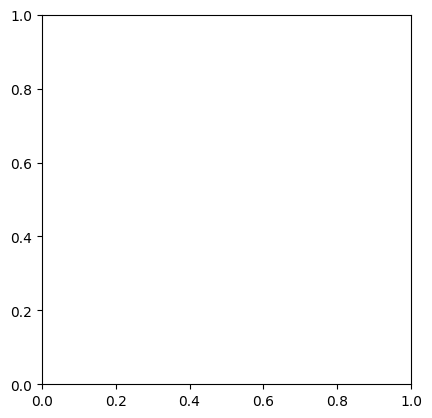

In [20]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
def test_reconstruct_with_PDHG():
    for rgb_image in load_images(["0065"], False):
        grayscale_image = rgb_image.convert("L") # Convert to grayscale
        grayscale_image = resize_image(grayscale_image, 0.125)
        image_data = convert_to_numpy(grayscale_image)

        print(f"Image data shape: {image_data.shape}")

        image_data = convert_to_tensor(image_data)
        print(f"Image size: {image_data.size()}")
        print(f"PSNR of original image: {PSNR(image_data, image_data)} dB")
        plt.imshow(image_data.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        TEST_SIGMA = 0.5  # Relatively high noise
        constant_noise_img = add_noise(image_data, sigma=TEST_SIGMA)
        print(f"PSNR of constant noise image: {PSNR(image_data, constant_noise_img):.2f} dB")
        plt.imshow(constant_noise_img.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        # TEST_LAMBDA = 0.1 # A test value to see the effect of lambda on regularization
        # TEST_LAMBDA = 0.2 # A test value to see the effect of lambda on regularization
        TEST_LAMBDA = 0.04
        pdhg_input = constant_noise_img
        # pdhg_input = pdhg_input.unsqueeze(0)
        pdhg_input = pdhg_input.unsqueeze(1)
        pdhg_input = pdhg_input.squeeze(-1)
        print(f"PDHG input size: {pdhg_input.size()}")
        # reconstructed_img = reconstruct_with_PDHG(
        #     pdhg_input, 
        #     lambda_reg=TEST_LAMBDA, 
        #     T=128
        #     # T=1000
        #     )


        # Model
        # lambda_map = TEST_LAMBDA * torch.ones_like(pdhg_input)
        lambda_map = TEST_LAMBDA
        model = UnrolledPrimalDualDenoising(num_iterations, lambda_map)

        # Denoise the image
        reconstructed_img = model(pdhg_input)
        resconstructed_image_data = reconstructed_img
        resconstructed_image_data = resconstructed_image_data.unsqueeze(0)
        print(f"Reconstructed image data shape: {resconstructed_image_data.shape}")
        plt.imshow(resconstructed_image_data.squeeze(0).squeeze(0).to("cpu").detach().numpy(), cmap='gray')
        plt.show();

        print(f"PSNR of reconstructed image: {PSNR(image_data, resconstructed_image_data):.2f} dB")


    with torch.no_grad():
        torch.cuda.empty_cache()

    print("""
In this example, a lot of noise has been applied to the original image. The PDHG algorithm tries to reconstruct the image from the noisy image. It did remove some noise and improved the PSNR value. However, the quality has been degraded significantly. We will see whether we can improve this by learning a set of parameters map.
""")
    
    # The lambda parameter is the regularization parameter. The higher the lambda, the more the regularization. The T parameter is the number of iterations. The higher the T, the more the iterations. The PSNR value is the Peak Signal to Noise Ratio. The higher the PSNR, the better the reconstruction.

test_reconstruct_with_PDHG()